In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

In [3]:
# dfs = [pd.read_csv('warm_start_comparison_0_7.csv'),
#        pd.read_csv('warm_start_comparison.csv')]
# df = pd.concat(dfs)
# df.to_csv('warm_start_comparison_06_21_22.csv', index=False)

In [9]:
raw_cut_df = pd.read_csv('data/tiny/cut_iteration.csv', keep_default_na=False)
raw_restart_df = pd.read_csv('data/tiny/restart.csv')
experiment_df = pd.read_csv('data/tiny/restart.csv')

In [10]:
raw_cut_df

,instance,cuts,disjunctive terms,cut generation iteration,root gap closed
0,flugpl,default,8,1,2.035572e-14
1,flugpl,default,8,2,1.173853e-01
2,flugpl,default,8,3,4.139344e-01
3,flugpl,default,8,4,4.722695e-01
4,flugpl,default,8,5,4.994662e-01
...,...,...,...,...,...
1495,bm23,default and disjunctive,16,96,4.042778e-01
1496,bm23,default and disjunctive,16,97,4.042778e-01
1497,bm23,default and disjunctive,16,98,4.042778e-01
1498,bm23,default and disjunctive,16,99,4.042778e-01


In [11]:
# group dual bound progress at root by cuts applied and disjunctive terms
cut_df = dict(tuple(raw_cut_df.groupby(['cuts', 'disjunctive terms'])))
cuts = list({k[0] for k in cut_df})
disjunctive_term_list = list({k[1] for k in cut_df})

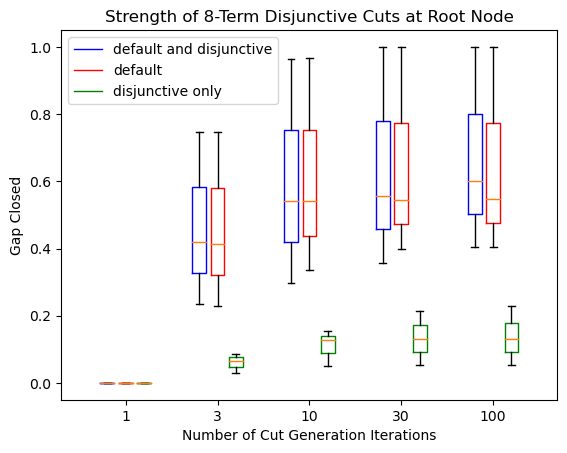

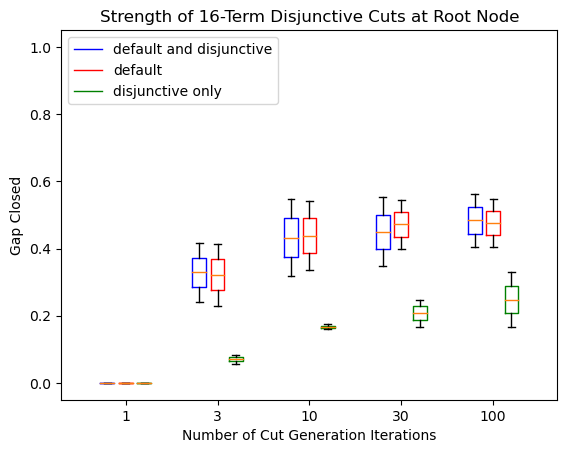

In [12]:
# which cut generation iterations to plot
iterations = [1, 3, 10, 30, 100]

# parameters for generating box plots
shift = .2
colors = ['b', 'r', 'g']  # must have same length as cuts
bp = {}

# make one plot for each number of disjunctive terms used
for disjunctive_terms in disjunctive_term_list:
    fig, ax = plt.subplots()
    
    # make a collection of box plots for each set of cuts used, plotting selected iterations
    for i, cut in enumerate(cuts):
        
        # get the dual bound progress for this combo of disjunctive term and type of cuts
        df = cut_df[cut, disjunctive_terms]
        
        # filter down to iterations of interest
        df = df[df['cut generation iteration'].isin(iterations)]
        
        # make one box plot for each cut generation iteration of interest
        gb = dict(tuple(df.groupby(['cut generation iteration'])['root gap closed']))
        bp[cut] = ax.boxplot(gb.values(), positions=np.arange(len(iterations))+(i - 1)*shift,
                             boxprops=dict(color=colors[i]), widths=.15)

    # set plot attributes
    ax.legend([b["boxes"][0] for b in bp.values()], bp.keys(), loc='upper left')
    ax.set_xticks(np.arange(len(iterations)))
    ax.set_xticklabels(iterations)
    ax.set(
        title=f'Strength of {disjunctive_terms}-Term Disjunctive Cuts at Root Node',
        xlabel='Number of Cut Generation Iterations',
        ylabel='Gap Closed',
        ylim=(-.05,1.05)
    )

    plt.show()

In [13]:
raw_restart_df.head()

,instance,disjunctive terms,restart,root gap closed
0,flugpl,8,0,2.035572e-14
1,flugpl,8,1,8.369167e-02
2,flugpl,8,2,1.309551e-01
3,flugpl,16,0,2.035572e-14
4,flugpl,16,1,8.370662e-02


In [14]:
# group dataframe by number of disjunctive terms
restart_df = dict(tuple(raw_restart_df.groupby('disjunctive terms')[['restart', 'root gap closed']]))

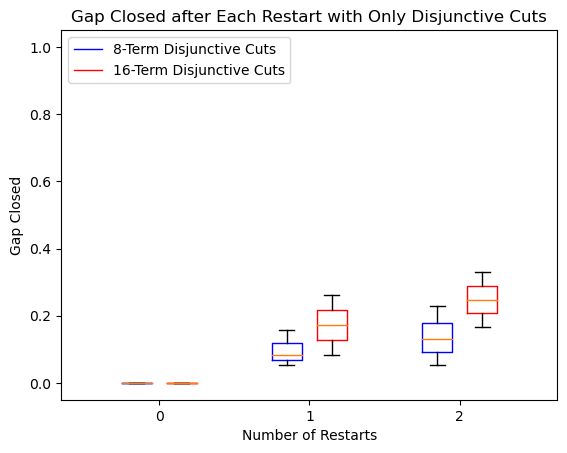

In [15]:
# make one plot for each number of disjunctive terms used
fig, ax = plt.subplots()

# parameters for generating box plots
shift = .3
colors = ['b', 'r']  # must have same length as restarts
bp = {}

# for each number of disjunctive terms plot progress of each subsequent restart as box plot
for i, (disjunctive_terms, df) in enumerate(restart_df.items()):
    
    # for each number of disjunctive terms group data frame by restart
    gb = dict(tuple(df.groupby(['restart'])['root gap closed']))
    
    # plot each restart as a boxplot
    bp[disjunctive_terms] = ax.boxplot(gb.values(), positions=np.arange(len(gb))+(i - .5)*shift,
                                       boxprops=dict(color=colors[i]), widths=.2)

# set plot attributes
ax.legend([b["boxes"][0] for b in bp.values()], [f'{x}-Term Disjunctive Cuts' for x in bp],
          loc='upper left')
ax.set_xticks(np.arange(len(gb)))
ax.set_xticklabels(gb.keys())
ax.set(
    title=f'Gap Closed after Each Restart with Only Disjunctive Cuts',
    xlabel='Number of Restarts',
    ylabel='Gap Closed',
    ylim=(-.05,1.05)
)

plt.show()

In [16]:
experiment_df

,instance,disjunctive terms,restart,root gap closed
0,flugpl,8,0,2.035572e-14
1,flugpl,8,1,8.369167e-02
2,flugpl,8,2,1.309551e-01
3,flugpl,16,0,2.035572e-14
4,flugpl,16,1,8.370662e-02
5,flugpl,16,2,1.667732e-01
6,p0033,8,0,3.672038e-13
7,p0033,8,1,5.265082e-02
8,p0033,8,2,5.267289e-02
9,bm23,8,0,0.000000e+00
